In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from datetime import date # PASTIKAN BARIS INI ADA!

# ... sisa kode Anda

Pengumpulan Data

---



In [7]:
# Unduh data harga Ethereum
df = yf.download('ETH-USD', start='2021-01-01', end='2025-07-01')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)
df.head()

/tmp/ipython-input-7-3005961522.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('ETH-USD', start='2021-01-01', end='2025-07-01')
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
Date,,,,,
2021-01-01,737.708374,749.201843,719.792236,730.367554,13652004358
2021-01-02,730.402649,786.798462,718.109497,774.534973,19740771179
2021-01-03,774.511841,1006.565002,771.561646,975.507690,45200463368
2021-01-04,977.058838,1153.189209,912.305359,1040.233032,56945985763
2021-01-05,1041.498779,1129.371460,986.811279,1100.006104,41535932781


In [9]:
df.shape

(1642, 5)

In [32]:
# Mengecek Data Duplikat
duplicates = df.duplicated()

# Menampilkan Baris yang Duplikat
print("Baris yang Duplikat:")
print(df[duplicates])

# Menampilkan Jumlah Data Duplikat
print("\nJumlah Data Duplikat:")
print(duplicates.sum())

Baris yang Duplikat:
Empty DataFrame
Columns: [(Close, ETH-USD), (target, ), (lag_1, ), (lag_3, ), (lag_7, ), (lag_14, ), (ma_7, ), (ma_14, ), (ma_30, )]
Index: []

Jumlah Data Duplikat:
0


Feature Enginering

In [ ]:
# Membuat fitur baru dari data yang ada untuk membantu model belajar

# Target yang akan diprediksi adalah harga penutupan (Close) esok hari.
# Kita geser kolom 'Close' satu hari ke depan sebagai target kita.
# Access columns using the MultiIndex
df['target'] = df[('Close')].shift(-1)

# Creating lag features (yesterday's closing price, 3 days ago, 7 days ago)
for i in [1, 3, 7, 14]:
    df[f'lag_{i}'] = df[('Close')].shift(i)

# Creating Moving Average features
for w in [7, 14, 30]:
    df[f'ma_{w}'] = df[('Close')].rolling(window=w).mean()

# Drop columns that are not needed for features, accessing by the MultiIndex
columns_to_drop = [('Open'), ('High'), ('Low'), ('Volume')]
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)


# Menghapus baris yang mengandung nilai NaN (Not a Number)
# Baris ini muncul karena proses shifting dan rolling window
df.dropna(inplace=True)
print("Feature Engineering")
print("Contoh data setelah Feature Engineering:")
print(df.tail())

Feature Engineering
Contoh data setelah Feature Engineering:
Price             Close       target        lag_1        lag_3        lag_7  \
Ticker          ETH-USD                                                       
Date                                                                          
2025-06-25  2419.310303  2416.146729  2448.008789  2228.213135  2524.301514   
2025-06-26  2416.146729  2423.866943  2419.310303  2421.824951  2521.653564   
2025-06-27  2423.866943  2437.109375  2416.146729  2448.008789  2407.304199   
2025-06-28  2437.109375  2500.959961  2423.866943  2419.310303  2300.495605   
2025-06-29  2500.959961  2486.464355  2437.109375  2416.146729  2228.213135   

Price            lag_14         ma_7        ma_14        ma_30  
Ticker                                                          
Date                                                            
2025-06-25  2773.529297  2392.401507  2473.860073  2540.521118  
2025-06-26  2651.795166  2377.329102  2457.028

/tmp/ipython-input-10-3029234274.py:19: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(columns=columns_to_drop, errors='ignore', inplace=True)


In [11]:
df.shape

(1612, 9)

Split Data

In [14]:
from sklearn.model_selection import train_test_split

# Memisahkan fitur (X) dan target (y)
from sklearn.model_selection import train_test_split

# Memisahkan fitur (X) dan target (y)
X = df.drop(['target'], axis=1) # Hanya gunakan fitur buatan kita
y = df['target']

# Membagi data menjadi 80% untuk latihan dan 20% untuk pengujian
# shuffle=False sangat PENTING untuk data time-series agar urutan waktu tidak rusak
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"\n📊 Ukuran data Latihan (Train): {X_train.shape}")
print(f"📊 Ukuran data Uji (Test):    {X_test.shape}")


📊 Ukuran data Latihan (Train): (1289, 8)
📊 Ukuran data Uji (Test):    (323, 8)


Pembuatan Model

In [26]:
print("\n⚙️  Membuat dan melatih model XGBoost...")

# Membuat model XGBoost Regressor dengan beberapa parameter awal
# 'n_estimators': jumlah pohon yang akan dibangun
# 'learning_rate': seberapa cepat model belajar
# 'early_stopping_rounds': berhenti jika performa tidak membaik setelah 50 iterasi
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)

# Melatih model
# eval_set digunakan untuk early stopping agar tidak overfitting
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False # Set ke True jika ingin melihat proses training
)
print("✅ Model berhasil dilatih.")


⚙️  Membuat dan melatih model XGBoost...
✅ Model berhasil dilatih.


Save Model

Evaluasi Model

In [30]:
print("\n📈 Mengevaluasi performa model...")

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Membuat prediksi pada data uji
predictions = model.predict(X_test)

# Menghitung metrik evaluasi
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Menampilkan hasil evaluasi
print(f"📉 Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"📈 R² Score: {r2:.4f}")


📈 Mengevaluasi performa model...
📉 Root Mean Squared Error (RMSE): $107.83
📈 R² Score: 0.9656


Visualisasi Hasil Prediksi


 Membuat visualisasi hasil prediksi...


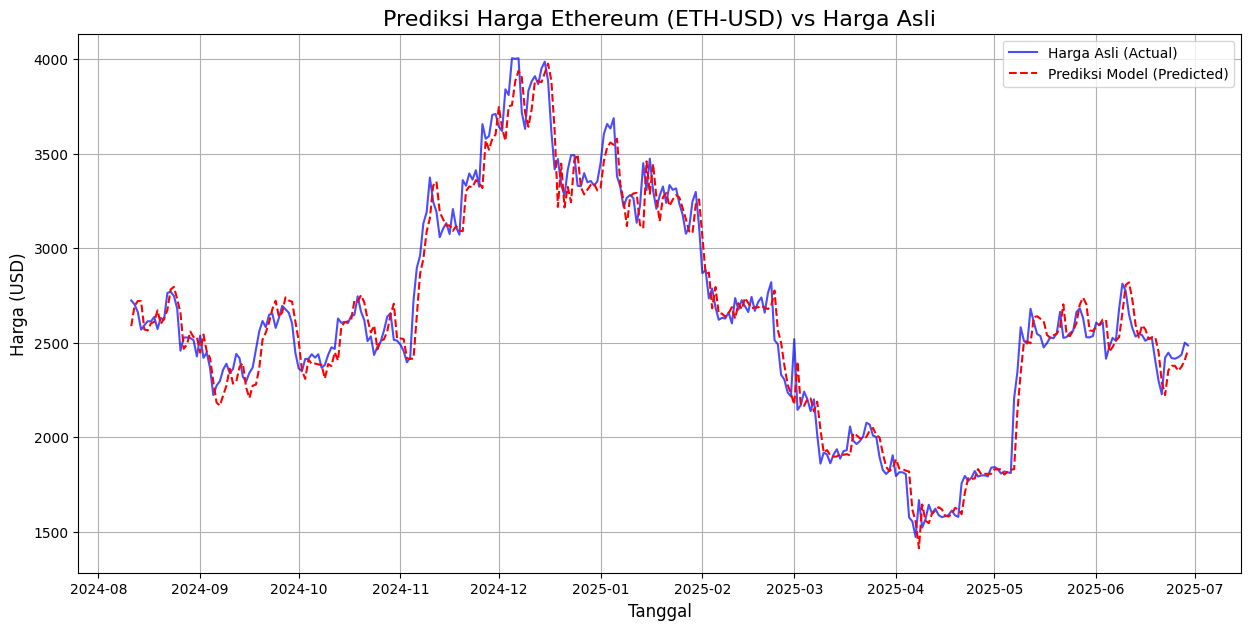

In [34]:
print("\n Membuat visualisasi hasil prediksi...")

# Membuat DataFrame untuk mempermudah plotting
results = pd.DataFrame({'Harga Asli': y_test, 'Prediksi Model': predictions})

plt.figure(figsize=(15, 7))
plt.plot(results.index, results['Harga Asli'], label='Harga Asli (Actual)', color='blue', alpha=0.7)
plt.plot(results.index, results['Prediksi Model'], label='Prediksi Model (Predicted)', color='red', linestyle='--')
plt.title('Prediksi Harga Ethereum (ETH-USD) vs Harga Asli', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga (USD)', fontsize=12)
plt.legend()
plt.grid(True)

# Simpan gambar dengan dpi 300
plt.savefig("prediksi_ethereum.png", dpi=300, bbox_inches='tight')  # kamu bisa ganti nama file sesuai kebutuhan

plt.show()


In [29]:
print("\n🚀 Memprediksi harga untuk hari berikutnya...")

# Ambil data paling akhir untuk membuat prediksi besok
last_data_point = X.iloc[[-1]]

# Lakukan prediksi
predicted_price_tomorrow = model.predict(last_data_point)

# Need to get the key for the 'Close' column from the original df for the current price
current_price_key = None
if isinstance(df.columns, pd.MultiIndex):
     for col in df.columns:
        if isinstance(col, tuple) and 'Close' in col:
            current_price_key = col
            break
if current_price_key is None:
     if ('Close') in df.columns:
          current_price_key = ('Close')
     elif 'Close' in df.columns:
          current_price_key = 'Close'
     else:
          raise ValueError("Could not find 'Close' column in df for current price display.")

# Access the last 'Close' price correctly
current_price = float(df[current_price_key].iloc[-1])


print(f"\nHarga Ethereum saat ini (terakhir di data): ${current_price:.2f}")
print(f"Prediksi harga Ethereum untuk esok hari: ${predicted_price_tomorrow[0]:.2f}")


🚀 Memprediksi harga untuk hari berikutnya...

Harga Ethereum saat ini (terakhir di data): $2500.96
Prediksi harga Ethereum untuk esok hari: $2465.08


In [35]:
import os

# Simpan model
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model using save_model
model.save_model('models/XGBOOST_MODEL.json') # XGBoost recommends saving in JSON format

print("\nModel XGBoost berhasil dilatih dan disimpan di 'models'")


Model XGBoost berhasil dilatih dan disimpan di 'models'
